<a href="https://colab.research.google.com/github/MEskerod/RNA_UNET/blob/main/experiments/RNAUnet_hyperparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch, pickle, sys, time, tarfile, os

import pandas as pd

from collections import namedtuple
from sklearn.model_selection import KFold
from itertools import product
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn


In [3]:
sys.path.append('/content/drive/MyDrive')

import utils

# Functions

In [4]:
class RNA_Unet(nn.Module):
    def __init__(self, channels=32, in_channels=8, output_channels=1, negative_slope = 0.01, pooling = utils.MaxPooling):
        """
        Pytorch implementation of a Unet for RNA secondary structure prediction

        Parameters:
        - channels (int): number of channels in the first hidden layer.
        - in_channels (int): number of channels in the input layer
        - output_channels (int): number of channels in the output layer
        - negative_slope (float): negative slope for the LeakyReLU activation function
        - pooling (nn.Module): the pooling layer to use
        """
        super(RNA_Unet, self).__init__()

        self.negative_slope = negative_slope

        #Add padding layer to make input size compatible with the Unet
        self.pad = utils.DynamicPadLayer(2**4)

        # Encoder
        self.e1 = nn.Sequential(
           nn.Conv2d(in_channels, channels, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels),
           nn.LeakyReLU(negative_slope=negative_slope),
           nn.Conv2d(channels, channels, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels),
           nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.pool1 = pooling(channels, channels, kernel_size=2, stride=2)

        self.e2 = nn.Sequential(
            nn.Conv2d(channels, channels*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*2),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(channels*2, channels*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*2),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.pool2 = pooling(channels*2, channels*2, kernel_size=2, stride=2)

        self.e3 = nn.Sequential(
            nn.Conv2d(channels*2, channels*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*4),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(channels*4, channels*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*4),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.pool3 = pooling(channels*4, channels*4, kernel_size=2, stride=2)

        self.e4 = nn.Sequential(
            nn.Conv2d(channels*4, channels*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*8),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(channels*8, channels*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*8),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.pool4 = pooling(channels*8, channels*8, kernel_size=2, stride=2)

        self.e5 = nn.Sequential(
            nn.Conv2d(channels*8, channels*16, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*16),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(channels*16, channels*16, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels*16),
            nn.LeakyReLU(negative_slope=negative_slope),
        )

        #Decoder
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(channels*16, channels*8, kernel_size=2, stride=2),
            nn.BatchNorm2d(channels*8),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.d1 = nn.Sequential(
           nn.Conv2d(channels*16, channels*8, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels*8),
           nn.LeakyReLU(negative_slope=negative_slope),
           nn.Conv2d(channels*8, channels*8, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels*8),
           nn.LeakyReLU(negative_slope=negative_slope),
        )

        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(channels*8, channels*4, kernel_size=2, stride=2),
            nn.BatchNorm2d(channels*4),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.d2 = nn.Sequential(
           nn.Conv2d(channels*8, channels*4, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels*4),
           nn.LeakyReLU(negative_slope=negative_slope),
           nn.Conv2d(channels*4, channels*4, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels*4),
           nn.LeakyReLU(negative_slope=negative_slope),
        )

        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(channels*4, channels*2, kernel_size=2, stride=2),
            nn.BatchNorm2d(channels*2),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.d3 = nn.Sequential(
           nn.Conv2d(channels*4, channels*2, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels*2),
           nn.LeakyReLU(negative_slope=negative_slope),
           nn.Conv2d(channels*2, channels*2, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels*2),
           nn.LeakyReLU(negative_slope=negative_slope),
        )

        self.upconv4 = nn.Sequential(
            nn.ConvTranspose2d(channels*2, channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(negative_slope=negative_slope),
        )
        self.d4 = nn.Sequential(
           nn.Conv2d(channels*2, channels, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels),
           nn.LeakyReLU(negative_slope=negative_slope),
           nn.Conv2d(channels, channels, kernel_size=3, padding=1),
           nn.BatchNorm2d(channels),
           nn.LeakyReLU(negative_slope=negative_slope),
        )

        self.out = nn.Sequential(nn.Conv2d(channels, output_channels, kernel_size=1),
                                 nn.Sigmoid())

        # Initialize weights
        self.init_weights()

    def init_weights(self):
      for layer in self.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
          gain = nn.init.calculate_gain("leaky_relu", self.negative_slope)
          nn.init.xavier_uniform_(layer.weight, gain=gain)
          nn.init.zeros_(layer.bias)
        elif isinstance(layer, nn.BatchNorm2d):
          nn.init.constant_(layer.weight, 1)
          nn.init.constant_(layer.bias, 0)


    def forward(self, x):
        dim = x.shape[2] #Keep track of the original dimension of the input to remove padding at the end
        x = self.pad(x)

        #Encoder
        xe1 = self.e1(x)
        xp1 = self.pool1(xe1)

        xe2 = self.e2(xp1)
        xp2 = self.pool2(xe2)

        xe3 = self.e3(xp2)
        xp3 = self.pool3(xe3)

        xe4 = self.e4(xp3)
        xp4 = self.pool4(xe4)

        xe5 = self.e5(xp4)

        #Decoder
        xu1 = self.upconv1(xe5)
        xu11 = torch.cat([xu1, xe4], dim=1)
        xd1 = self.d1(xu11)

        xu2 = self.upconv2(xd1)
        xu22 = torch.cat([xu2, xe3], dim=1)
        xd2 = self.d2(xu22)

        xu3 = self.upconv3(xd2)
        xu33 = torch.cat([xu3, xe2], dim=1)
        xd3 = self.d3(xu33)

        xu4 = self.upconv4(xd3)
        xu44 = torch.cat([xu4, xe1], dim=1)
        xd4 = self.d4(xu44)

        out = self.out(xd4)

        out = out[:, :, :dim, :dim]

        return out

In [5]:
def train_model(params, train_dataset, validation_dataset, loss_func = utils.dice_loss, optimizer = utils.adam_optimizer, lr=0.01, bs=1, epochs=10, df = None, output_file = None):
  if df is None:
    df = pd.DataFrame(columns=["Training_loss", "Training_f1", "Validation_loss", "Validation_f1"])

  print(f"Training with parameters: {params}")

  model = RNA_Unet(channels = params["conv2_filters"])

  train_dl = DataLoader(train_dataset, batch_size = bs, shuffle = True)
  valid_dl = DataLoader(validation_dataset, batch_size = bs)

  if not params["weight_decay"]:
    opt = optimizer(model, lr)
  else:
    opt = optimizer(model, lr, params["weight_decay"])

  #Add stuff to track history
  train_loss_history = []
  train_F1_history = []
  valid_loss_history = []
  valid_F1_history = []

  device = 'cpu'
  if torch.cuda.is_available():
    device = 'cuda:0'

  model.to(device)

  for epoch in range(epochs):
    running_loss = 0.0
    running_F1 = 0.0

    model.train()

    for input, output, _ in train_dl:
      input, output = input.to(device), output.to(device).unsqueeze(1) #Since output is made from NxN matrix, we need to unsqueeze to get channel dimension

      #Forward pass
      opt.zero_grad()
      predicted = model(input)

      #Compute loss
      loss = loss_func(predicted, output)
      running_loss += loss.item()
      running_F1 += utils.f1_score(predicted, output).item()

      #Backpropagation and optimization
      loss.backward()
      opt.step()

    #Validation loss (after each epoch)
    valid_loss, valid_F1 = 0.0, 0.0
    with torch.no_grad():
      for valid_input, valid_output, _ in valid_dl:
        valid_input, valid_output = valid_input.to(device), valid_output.to(device).unsqueeze(1)
        predicted_valid = model(valid_input)

        valid_loss += loss_func(predicted_valid, valid_output).item()
        valid_F1 += utils.f1_score(predicted_valid, valid_output).item()

    train_loss = running_loss/len(train_dl)
    valid_loss = valid_loss/len(valid_dl)

    valid_loss_history.append(valid_loss)
    valid_F1_history.append(valid_F1/len(valid_dl))
    train_loss_history.append(train_loss)
    train_F1_history.append(running_F1/len(train_dl))

    print(f"\tEpoch [{epoch + 1}/{epochs}], Loss: {round(train_loss,4)}, Validation: {round(valid_loss, 4)}")

  df.loc[f"wd: {params['weight_decay']}, filters:{params['conv2_filters']}"] = [train_loss_history, train_F1_history, valid_loss_history, valid_F1_history]

  if output_file:
    df.to_csv(output_file)

  utils.show_loss(train_loss_history, valid_loss_history, list(range(1, epochs+1)))
  utils.show_F1(train_F1_history, valid_F1_history, list(range(1, epochs+1)))

  print(f"Finished training with parameters: {params}")

  return df



# Hyper-parameter search

In [6]:
RNA_data = namedtuple('RNA_data', 'input output length family name pairs')

# Define the path to the zipped folder in your Google Drive
tar_file_path = '/content/drive/MyDrive/data/experiment8.tar.gz'
# Extract the tar.gz archive
with tarfile.open(tar_file_path, 'r:gz') as tar:
    tar.extractall('/content')

train = pickle.load(open('/content/drive/MyDrive/data/experiment_train.pkl', 'rb'))
valid = pickle.load(open('/content/drive/MyDrive/data/experiment_valid.pkl', 'rb'))
family_map = pickle.load(open('/content/drive/MyDrive/data/experiment_familymap.pkl', 'rb'))

train_dataset = utils.ImageToImageDataset(train, family_map)
valid_dataset = utils.ImageToImageDataset(valid, family_map)


In [7]:
params = {
       "weight_decay": [0.0001, 0.00001, None],
       "conv2_filters": [32, 64],
       }

params = [{"weight_decay": wd, "conv2_filters": cf} for wd, cf in product(params["weight_decay"], params["conv2_filters"])]

print(f"Number of combinations: {len(params)}")

Number of combinations: 6


In [8]:
df = pd.read_csv('/content/drive/MyDrive/results/RNAunet_hyperparam.csv', index_col = 0)
df

,Training_loss,Training_f1,Validation_loss,Validation_f1
"wd: 0.0001, filters:32","[0.2030632044277052, 0.1741530534841309, 0.169...","[0.7665021005622841, 0.7988141020232897, 0.804...","[0.17418571910358113, 0.16503070138593992, 0.1...","[0.797627922063253, 0.8105412727761874, 0.7936..."
"wd: None, filters:32","[0.1351647595163577, 0.08076114077177003, 0.06...","[0.8461755301095562, 0.9060924981453226, 0.925...","[0.09226692125272719, 0.07276533330606222, 0.0...","[0.89355757104321, 0.9137432187427962, 0.92315..."
"wd: 0.0001, filters:64","[0.2340966688967304, 0.17191914707460645, 0.16...","[0.7413717292640286, 0.8014720587425347, 0.805...","[0.18219547765233732, 0.1702054057773292, 0.16...","[0.7896145893499572, 0.8032319446166465, 0.814..."
"wd: 1e-05, filters:32","[0.19229161442989645, 0.1297711114967366, 0.12...","[0.7855864487096152, 0.8499639166954917, 0.855...","[0.1400227920906114, 0.12935053981518893, 0.12...","[0.8374442563145188, 0.8496830746265942, 0.856..."


## Training for each combination of hyper-parameters

Training with parameters: {'weight_decay': 0.0001, 'conv2_filters': 32}
	Epoch [1/10], Loss: 0.2031, Validation: 0.1742
	Epoch [2/10], Loss: 0.1742, Validation: 0.165
	Epoch [3/10], Loss: 0.1696, Validation: 0.1798
	Epoch [4/10], Loss: 0.1681, Validation: 0.1608
	Epoch [5/10], Loss: 0.1668, Validation: 0.1699
	Epoch [6/10], Loss: 0.1651, Validation: 0.1566
	Epoch [7/10], Loss: 0.1644, Validation: 0.1637
	Epoch [8/10], Loss: 0.1648, Validation: 0.156
	Epoch [9/10], Loss: 0.1638, Validation: 0.1818
	Epoch [10/10], Loss: 0.1624, Validation: 0.2154


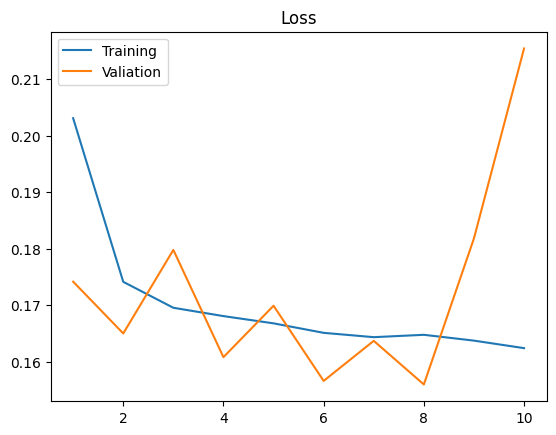

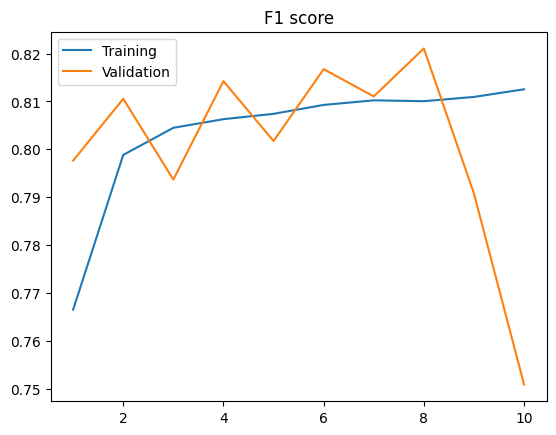

Finished training with parameters: {'weight_decay': 0.0001, 'conv2_filters': 32}


In [ ]:
df = train_model(params[0], train_dataset, valid_dataset, output_file='/content/drive/MyDrive/results/RNAunet_hyperparam.csv')

Training with parameters: {'weight_decay': 0.0001, 'conv2_filters': 64}
	Epoch [1/10], Loss: 0.2341, Validation: 0.1822
	Epoch [2/10], Loss: 0.1719, Validation: 0.1702
	Epoch [3/10], Loss: 0.1689, Validation: 0.161
	Epoch [4/10], Loss: 0.1676, Validation: 0.162
	Epoch [5/10], Loss: 0.1666, Validation: 0.1654
	Epoch [6/10], Loss: 0.1662, Validation: 0.1614
	Epoch [7/10], Loss: 0.1666, Validation: 0.194
	Epoch [8/10], Loss: 0.1658, Validation: 0.1665
	Epoch [9/10], Loss: 0.166, Validation: 0.1671
	Epoch [10/10], Loss: 0.1658, Validation: 0.161


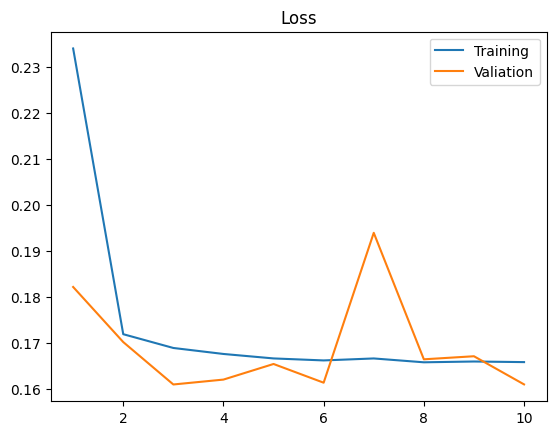

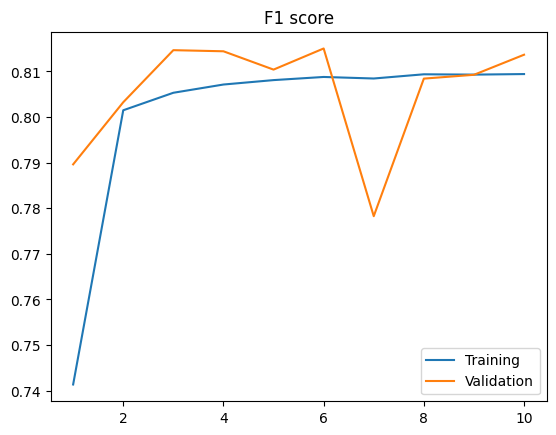

Finished training with parameters: {'weight_decay': 0.0001, 'conv2_filters': 64}


In [ ]:
df = train_model(params[1], train_dataset, valid_dataset, output_file='/content/drive/MyDrive/results/RNAunet_hyperparam.csv', df = df)

Training with parameters: {'weight_decay': 1e-05, 'conv2_filters': 32}
	Epoch [1/10], Loss: 0.1923, Validation: 0.14
	Epoch [2/10], Loss: 0.1298, Validation: 0.1294
	Epoch [3/10], Loss: 0.1244, Validation: 0.1225
	Epoch [4/10], Loss: 0.1217, Validation: 0.1219
	Epoch [5/10], Loss: 0.12, Validation: 0.1255
	Epoch [6/10], Loss: 0.1191, Validation: 0.1218
	Epoch [7/10], Loss: 0.118, Validation: 0.1184
	Epoch [8/10], Loss: 0.1171, Validation: 0.1175
	Epoch [9/10], Loss: 0.1169, Validation: 0.1248
	Epoch [10/10], Loss: 0.1164, Validation: 0.1384


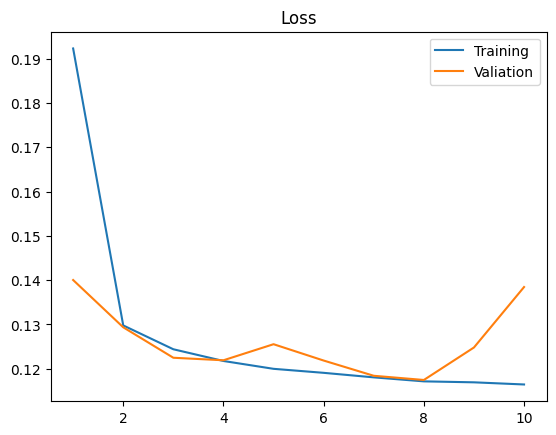

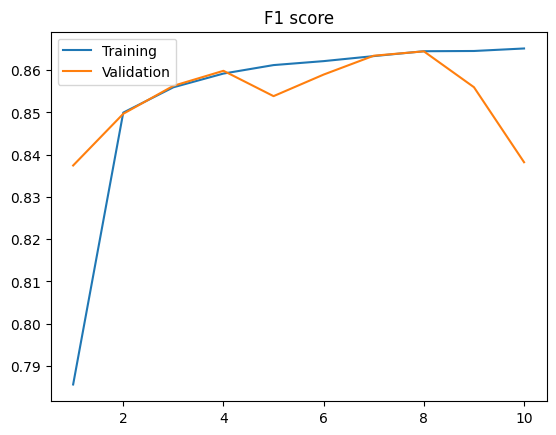

Finished training with parameters: {'weight_decay': 1e-05, 'conv2_filters': 32}


In [ ]:
df = train_model(params[2], train_dataset, valid_dataset, output_file='/content/drive/MyDrive/results/RNAunet_hyperparam.csv', df = df)

Training with parameters: {'weight_decay': 1e-05, 'conv2_filters': 64}
	Epoch [1/10], Loss: 0.2428, Validation: 0.1488
	Epoch [2/10], Loss: 0.1345, Validation: 0.1301
	Epoch [3/10], Loss: 0.1276, Validation: 0.1264
	Epoch [4/10], Loss: 0.1249, Validation: 0.1312
	Epoch [5/10], Loss: 0.1228, Validation: 0.1334
	Epoch [6/10], Loss: 0.121, Validation: 0.124
	Epoch [7/10], Loss: 0.12, Validation: 0.1241
	Epoch [8/10], Loss: 0.1193, Validation: 0.1125
	Epoch [9/10], Loss: 0.1189, Validation: 0.1227
	Epoch [10/10], Loss: 0.1182, Validation: 0.1204


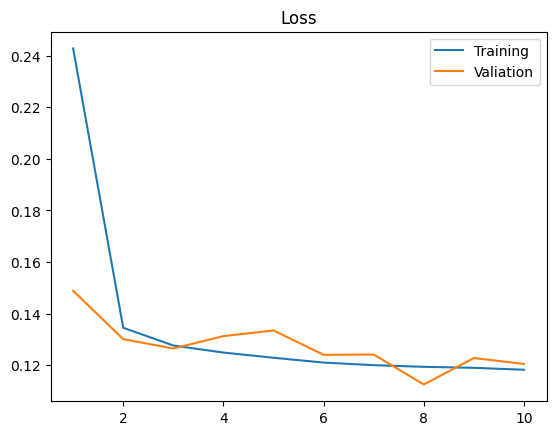

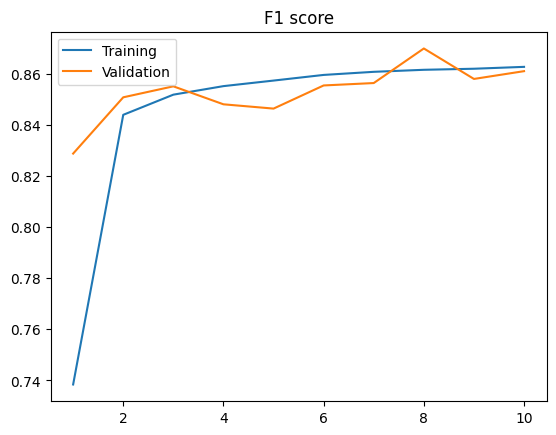

Finished training with parameters: {'weight_decay': 1e-05, 'conv2_filters': 64}


In [10]:
df = train_model(params[3], train_dataset, valid_dataset, output_file='/content/drive/MyDrive/results/RNAunet_hyperparam.csv', df = df)

Training with parameters: {'weight_decay': None, 'conv2_filters': 32}
	Epoch [1/10], Loss: 0.1352, Validation: 0.0923
	Epoch [2/10], Loss: 0.0808, Validation: 0.0728
	Epoch [3/10], Loss: 0.0634, Validation: 0.0658
	Epoch [4/10], Loss: 0.0538, Validation: 0.0547
	Epoch [5/10], Loss: 0.0472, Validation: 0.0491
	Epoch [6/10], Loss: 0.0424, Validation: 0.05
	Epoch [7/10], Loss: 0.0385, Validation: 0.0454
	Epoch [8/10], Loss: 0.0354, Validation: 0.0426
	Epoch [9/10], Loss: 0.0329, Validation: 0.0406
	Epoch [10/10], Loss: 0.0308, Validation: 0.0396


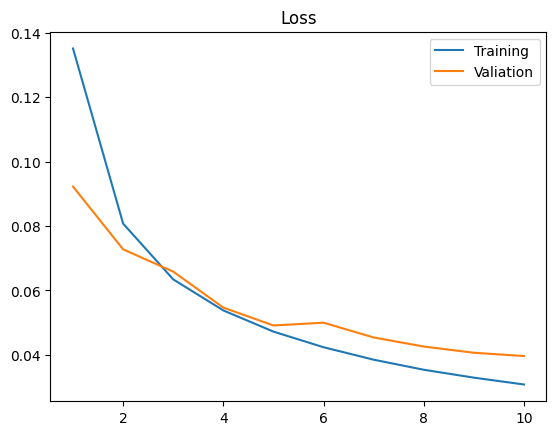

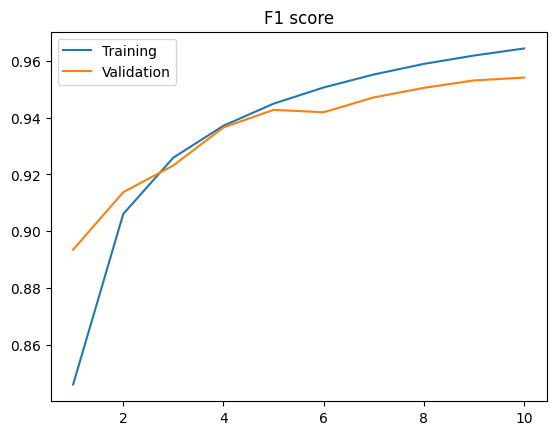

Finished training with parameters: {'weight_decay': None, 'conv2_filters': 32}


In [ ]:
df = train_model(params[4], train_dataset, valid_dataset, output_file='/content/drive/MyDrive/results/RNAunet_hyperparam.csv', df = df)

Training with parameters: {'weight_decay': None, 'conv2_filters': 64}
	Epoch [1/10], Loss: 0.1599, Validation: 0.0915
	Epoch [2/10], Loss: 0.0786, Validation: 0.0696
	Epoch [3/10], Loss: 0.0607, Validation: 0.0589
	Epoch [4/10], Loss: 0.0508, Validation: 0.0523
	Epoch [5/10], Loss: 0.0443, Validation: 0.0474
	Epoch [6/10], Loss: 0.0393, Validation: 0.0449
	Epoch [7/10], Loss: 0.0354, Validation: 0.0415
	Epoch [8/10], Loss: 0.0323, Validation: 0.041
	Epoch [9/10], Loss: 0.0299, Validation: 0.0378
	Epoch [10/10], Loss: 0.0278, Validation: 0.038


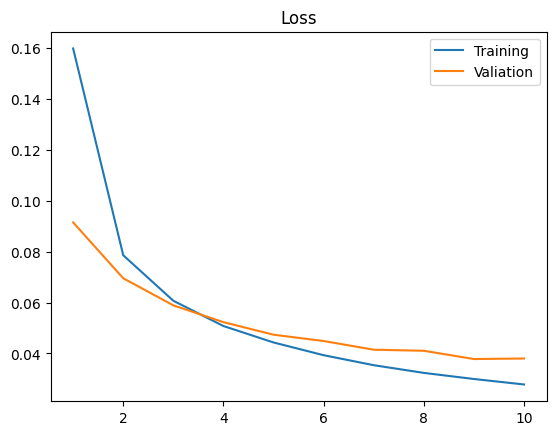

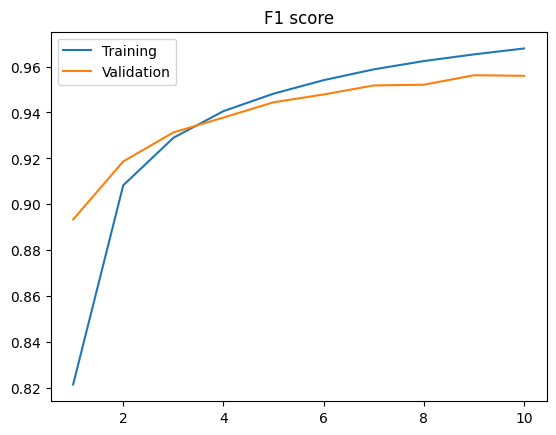

Finished training with parameters: {'weight_decay': None, 'conv2_filters': 64}


In [11]:
df = train_model(params[5], train_dataset, valid_dataset, output_file='/content/drive/MyDrive/results/RNAunet_hyperparam.csv', df = df)

## Plots

In [20]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl

def plot_f1_curves(training_df, output_file = None):
    """
    """
    colors = mpl.colormaps["tab10"].colors
    fig, ax = plt.subplots(constrained_layout=True, figsize = (10, 6))

    handles = []

    for index, (loss_name, row) in enumerate(training_df.iterrows()):
      training_f1 = eval(row["Training_f1"]) if type(row["Training_f1"]) == str else row["Training_f1"]
      valid_f1 = eval(row["Validation_f1"]) if type(row["Validation_f1"]) == str else row["Validation_f1"]

      x = [i for i in range(1, len(training_f1)+1)]

      ax.scatter(x=x, y=training_f1, marker="o", color=colors[index], s = 6)
      ax.scatter(x=x, y=valid_f1, marker="x", color=colors[index], s = 6)

      # Create line plots for training and validation
      ax.plot(x, training_f1, linestyle="-", color=colors[index], linewidth = 0.5)
      ax.plot(x, valid_f1, linestyle="--", color=colors[index], linewidth = 0.5)

      #Add handles for legend
      handles.append(Line2D([0], [0], color = colors[index], linestyle = "-", marker = "o", label = f"Training {loss_name}", linewidth=0.5, markersize=3))
      handles.append(Line2D([0], [0], color = colors[index], linestyle = "--", marker = "x", label = f"Validation {loss_name}", linewidth=0.5, markersize=3))

    ax.set_xlabel("Epochs", size = 11)
    ax.set_ylabel("F1 score", size = 11)
    ax.legend(handles = handles, loc = 'lower right', fontsize=8, frameon=False)
    ax.grid(linestyle='--')

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    if output_file:
      plt.savefig(output_file, dpi=300)

    plt.show()


def plot_loss_curves(training_df, output_file = None):
    """
    """
    colors = mpl.colormaps["tab10"].colors

    fig, ax = plt.subplots(constrained_layout=True, figsize = (10, 6))

    handles = []

    for index, (model_name, row) in enumerate(training_df.iterrows()):
      training_loss = eval(row["Training_loss"]) if type(row["Training_loss"]) == str else row["Training_loss"]
      valid_loss = eval(row["Validation_loss"]) if type(row["Validation_loss"]) == str else row["Validation_loss"]

      x = [i for i in range(1, len(training_loss)+1)]

      ax.scatter(x=x, y=training_loss, marker="o", color=colors[index], s=6)
      ax.scatter(x=x, y=valid_loss, marker="x", color=colors[index], s=6)

      # Create line plots for training and validation
      ax.plot(x, training_loss, linestyle="-", color=colors[index], linewidth = 0.5)
      ax.plot(x, valid_loss, linestyle="--", color=colors[index], linewidth = 0.5)

      #Add handles for legend
      handles.append(Line2D([0], [0], color = colors[index], linestyle = "-", marker = "o", label = f"Training {model_name}", linewidth=0.5, markersize=3))
      handles.append(Line2D([0], [0], color = colors[index], linestyle = "--", marker = "x", label = f"Validation {model_name}", linewidth=0.5, markersize=3))

    #ax.set_yscale('log')

    ax.set_xlabel("Epochs", size = 11)
    ax.legend(handles = handles, loc = 'upper right', fontsize=8, frameon=False)
    ax.grid(linestyle='--')


    ax.set_ylabel("Loss", size = 11)

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    if output_file:
      plt.savefig(output_file, dpi=300)

    plt.show()

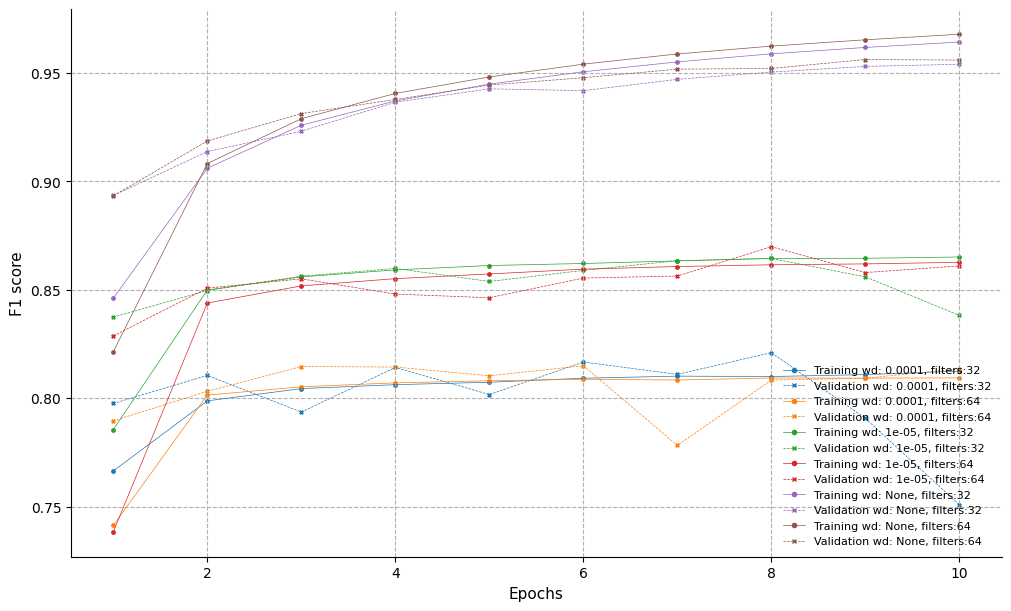

In [22]:
utils.plot_f1_curves(df, output_file = '/content/drive/MyDrive/results/RNAunet_hyperparam_f1.png');

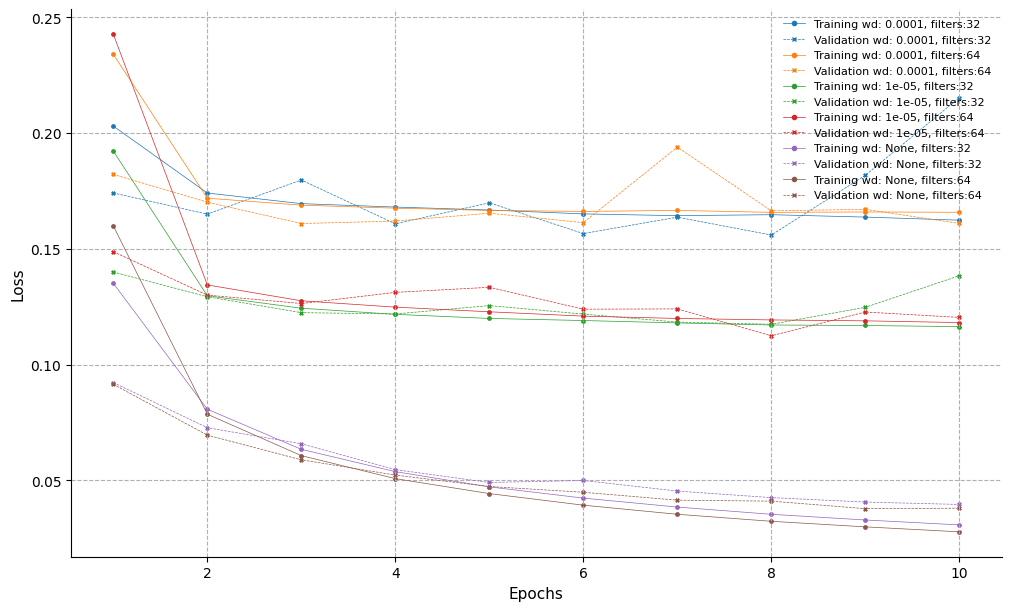

In [23]:
utils.plot_loss_curves(df, output_file = '/content/drive/MyDrive/results/RNAunet_hyperparam_loss.png');